In [1]:
class Layer:
    def __init__(self):
        self.input = None
        self.output = None
        
    def forward_propagation(self, input):
        raise NotImplementedError
        
    def backward_propagation(self, output_error, learning_rate):
        raise NotImplementedError

In [2]:
import numpy as np

class FCLayer(Layer):
    def __init__(self, input_size, output_size):
        self.weights = np.random.rand(input_size, output_size) - 0.5
        self.bias = np.random.rand(1, output_size) - 0.5
        
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.output
    
    def backward_propagation(self, output_error, learning_rate):
        input_error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(self.input.T, output_error)
        
        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * output_error
        return input_error

In [3]:
class ActivationLayer(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime
        
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = self.activation(self.input)
        return self.output
    
    def backward_propagation(self, output_error, learning_rate):
        return self.activation_prime(self.input) * output_error

In [4]:
def tanh(x):
    return np.tanh(x)

def tanh_prime(x):
    return 1 - np.tanh(x)**2

In [5]:
def mse(y_true, y_pred):
    return np.mean(np.power(y_true-y_pred, 2))

def mse_prime(y_true, y_pred):
    return 2*(y_pred-y_true)/y_true.size

In [6]:
class Network:
    def __init__(self):
        self.layers = []
        self.loss = None
        self.loss_prime = None
        self.error_tape = []
        self.accuracy_tape = []
        self.cat_accuracy_tape = []
        
    def add(self, layer):
        self.layers.append(layer)
        
    def use(self, loss, loss_prime):
        self.loss = loss
        self.loss_prime = loss_prime
        
    def predict(self, input_data):
        samples = len(input_data)
        result = []
        
        for i in range(samples):
            output = input_data[i]
            for layer in self.layers:
                output = layer.forward_propagation(output)
            result.append(output)
            
        return result
    
    def categorical_accuracy(self, x_train, y_train):
        predict = self.predict(x_train)
        cat_accuracy = []
        for i in range(len(predict)):
            if y_train[i] == 1:
                if (predict[i] > 0.5):
                    cat_accuracy.append(1)
                    
                else:
                    cat_accuracy.append(0)
                    
            else:
                if (predict[i] < 0.5):
                    cat_accuracy.append(1)
                    
                else:
                    cat_accuracy.append(0)
                    
        return np.average(np.array(cat_accuracy))
    
    def fit(self, x_train, y_train, epochs, learning_rate):
        samples = len(x_train)
        
        for i in range(epochs):
            err = 0
            for j in range(samples):
                output = x_train[j]
                for layer in self.layers:
                    output = layer.forward_propagation(output)
                    
                err += self.loss(y_train[j], output)
                
                error = self.loss_prime(y_train[j], output)
                for layer in reversed(self.layers):
                    error = layer.backward_propagation(error, learning_rate)
                    
#             predict = np.array(self.predict(x_train))
#             accuracy_array = np.divide(1 - np.abs(predict - y_train), 1)
#             accuracy = np.average(accuracy_array)
                    
            err /= samples
            self.error_tape.append(err)
#             self.accuracy_tape.append(accuracy)
#             self.cat_accuracy_tape.append(self.categorical_accuracy(x_train, y_train))
            print('epoch %d/%d error=%f' % (i+1, epochs, err))

In [7]:
from keras.datasets import mnist
from keras.utils import np_utils

# load MNIST from server
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# training data : 60000 samples
# reshape and normalize input data
x_train = x_train.reshape(x_train.shape[0], 1, 28*28)
x_train = x_train.astype('float32')
x_train /= 255
# encode output which is a number in range [0,9] into a vector of size 10
# e.g. number 3 will become [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
y_train = np_utils.to_categorical(y_train)

# same for test data : 10000 samples
x_test = x_test.reshape(x_test.shape[0], 1, 28*28)
x_test = x_test.astype('float32')
x_test /= 255
y_test = np_utils.to_categorical(y_test)

# Network
net = Network()
net.add(FCLayer(28*28, 100))                # input_shape=(1, 28*28)    ;   output_shape=(1, 100)
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(100, 50))                   # input_shape=(1, 100)      ;   output_shape=(1, 50)
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(50, 10))                    # input_shape=(1, 50)       ;   output_shape=(1, 10)
net.add(ActivationLayer(tanh, tanh_prime))

# train on 1000 samples
# as we didn't implemented mini-batch GD, training will be pretty slow if we update at each iteration on 60000 samples...
net.use(mse, mse_prime)
net.fit(x_train[0:1000], y_train[0:1000], epochs=35, learning_rate=0.1)

# test on 3 samples
out = net.predict(x_test[0:3])
print("\n")
print("predicted values : ")
print(out, end="\n")
print("true values : ")
print(y_test[0:3])

epoch 1/35 error=0.238473
epoch 2/35 error=0.106689
epoch 3/35 error=0.081698
epoch 4/35 error=0.063923
epoch 5/35 error=0.053442
epoch 6/35 error=0.046235
epoch 7/35 error=0.040705
epoch 8/35 error=0.036520
epoch 9/35 error=0.032735
epoch 10/35 error=0.029470
epoch 11/35 error=0.026674
epoch 12/35 error=0.024050
epoch 13/35 error=0.021689
epoch 14/35 error=0.019708
epoch 15/35 error=0.017893
epoch 16/35 error=0.016432
epoch 17/35 error=0.015271
epoch 18/35 error=0.014362
epoch 19/35 error=0.013536
epoch 20/35 error=0.012724
epoch 21/35 error=0.012041
epoch 22/35 error=0.011483
epoch 23/35 error=0.010981
epoch 24/35 error=0.010510
epoch 25/35 error=0.010012
epoch 26/35 error=0.009621
epoch 27/35 error=0.009209
epoch 28/35 error=0.008897
epoch 29/35 error=0.008552
epoch 30/35 error=0.008251
epoch 31/35 error=0.007875
epoch 32/35 error=0.007653
epoch 33/35 error=0.007403
epoch 34/35 error=0.007175
epoch 35/35 error=0.006955


predicted values : 
[array([[-0.00275327,  0.01628546, -0.0410

In [8]:
import matplotlib.pyplot as plt

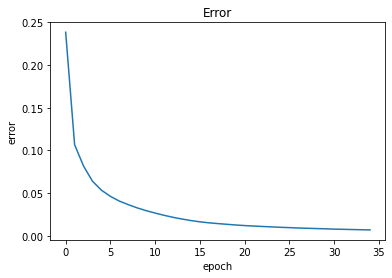

In [9]:
plt.xlabel("epoch")
plt.ylabel("error")
plt.title("Error")
plt.plot(range(len(net.error_tape)), net.error_tape)

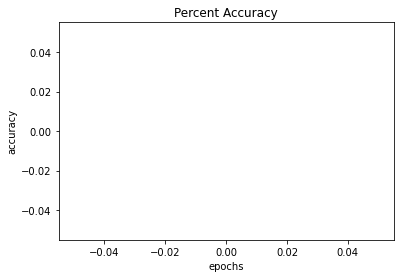

In [10]:
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("Percent Accuracy")
plt.plot(range(len(net.accuracy_tape)), net.accuracy_tape)

In [11]:
print(net.accuracy_tape[-1])

IndexError: list index out of range

In [ ]:
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Categorical Accuracy")
plt.plot(range(len(net.cat_accuracy_tape)), net.cat_accuracy_tape)

In [2]:
print(1 * (2 > 3))

0
